<a href="https://colab.research.google.com/github/Somasri/SKMLI-143_Tasks/blob/main/phase2(task2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
import joblib

# Step 1: Data Collection
data = pd.read_csv('/content/ride_requests_synthetic.csv')

# Step 2: Data Preprocessing
data = data.dropna()
X = data.drop(columns=['ride_requests'])
y = data['ride_requests']

# Ensure features are correctly classified as numeric or categorical
numeric_features = ['hour', 'temperature', 'humidity']
categorical_features = ['day_of_week', 'month', 'weather_condition', 'holiday']

# Defining the column transformer for preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define models
models = {
    'LinearRegression': LinearRegression(),
    'XGBRegressor': XGBRegressor(),
    'Lasso': Lasso(),
    'RandomForestRegressor': RandomForestRegressor(),
    'Ridge': Ridge()
}

# Hyperparameter tuning for RandomForestRegressor
param_grid_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
}
grid_search_rf = GridSearchCV(Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
]), param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X, y)
best_rf_model = grid_search_rf.best_estimator_

# Hyperparameter tuning for XGBRegressor
param_grid_xgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6, 10],
}
grid_search_xgb = GridSearchCV(Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
]), param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X, y)
best_xgb_model = grid_search_xgb.best_estimator_

print("Best RandomForestRegressor RMSE:", np.sqrt(-grid_search_rf.best_score_))
print("Best XGBRegressor RMSE:", np.sqrt(-grid_search_xgb.best_score_))


Best RandomForestRegressor RMSE: 43.89184701898597
Best XGBRegressor RMSE: 47.96255820777667


In [5]:
# Function to predict ride requests
def predict_ride_requests(model, hour, temperature, humidity, day_of_week, month, weather_condition, holiday):
    input_data = pd.DataFrame({
        'hour': [hour],
        'temperature': [temperature],
        'humidity': [humidity],
        'day_of_week': [day_of_week],
        'month': [month],
        'weather_condition': [weather_condition],
        'holiday': [holiday]
    })
    preprocessed_input = model.named_steps['preprocessor'].transform(input_data)
    prediction = model.named_steps['regressor'].predict(preprocessed_input)
    return prediction[0]

# Example prediction using the best RandomForestRegressor model
example_prediction = predict_ride_requests(
    best_rf_model,
    hour=14,
    temperature=25,
    humidity=60,
    day_of_week='Monday',
    month='July',
    weather_condition='Clear',
    holiday=1
)
print(f"Predicted ride requests: {example_prediction}")


Predicted ride requests: 137.9360941915766


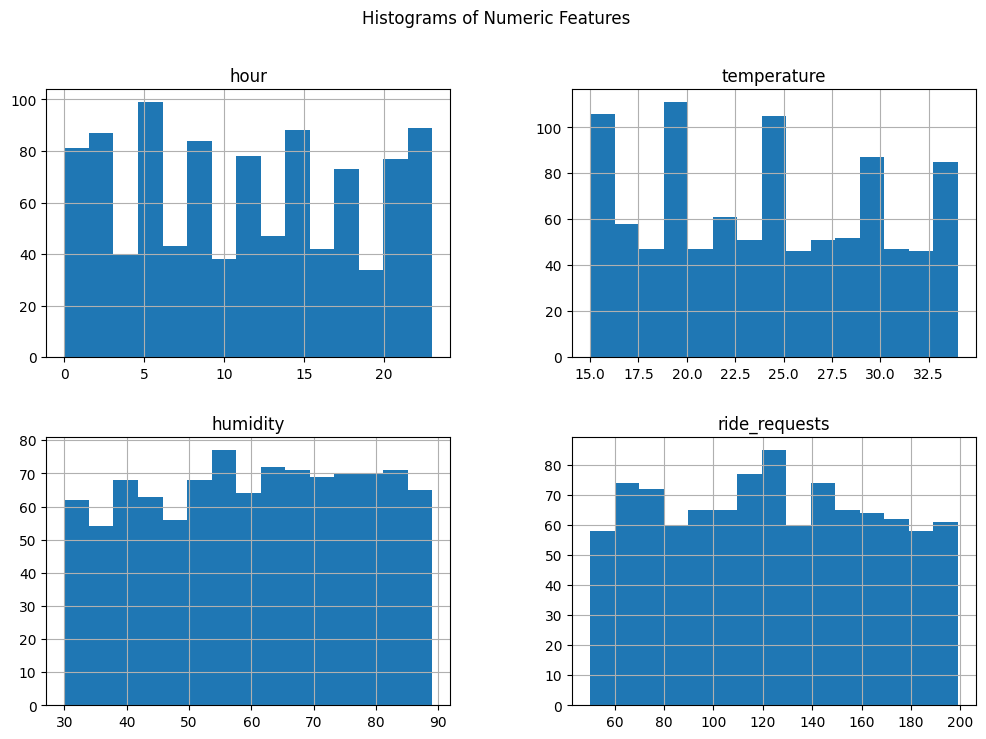

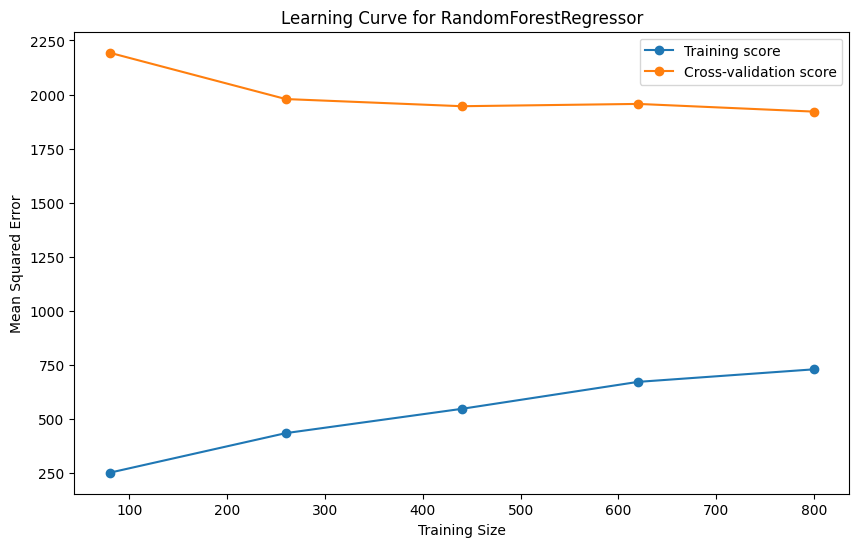

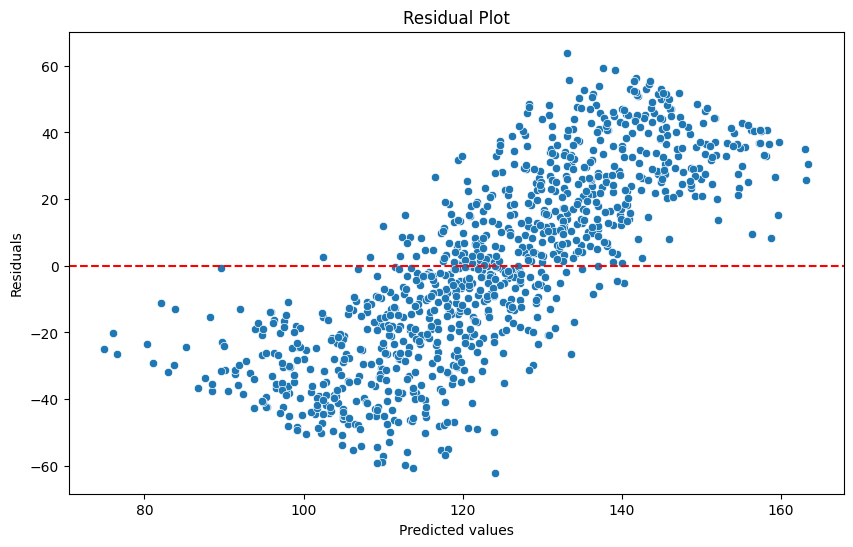

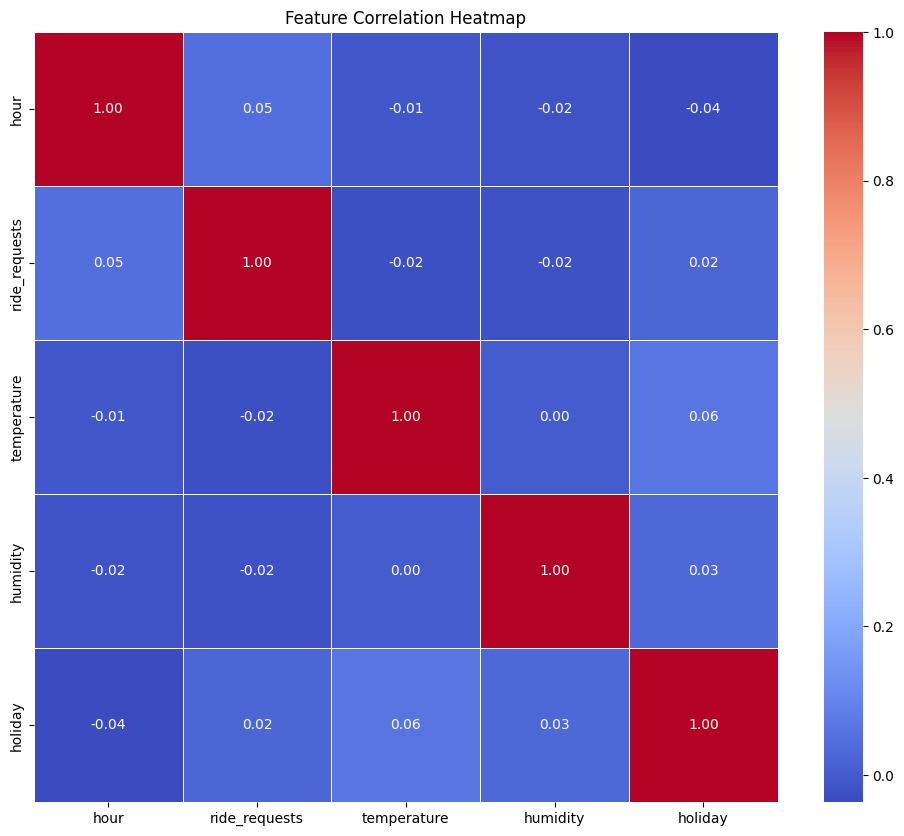

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_data_distribution(df):
    numeric_features = ['hour', 'temperature', 'humidity', 'ride_requests']
    df[numeric_features].hist(figsize=(12, 8), bins=15)
    plt.suptitle('Histograms of Numeric Features')
    plt.show()

plot_data_distribution(data)
# Learning Curves
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
    plt.xlabel('Training Size')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Learning Curve for {model.named_steps["regressor"].__class__.__name__}')
    plt.legend(loc='best')
    plt.show()

# Plot learning curves for RandomForestRegressor
plot_learning_curve(best_rf_model, X, y)

# Residual Plots
def plot_residuals(model, X, y):
    y_pred = model.predict(X)
    residuals = y - y_pred

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

# Plot residuals for the best RandomForestRegressor
plot_residuals(best_rf_model, X, y)

# Feature Correlation Heatmap
def plot_correlation_heatmap(data):
    numeric_data = data.select_dtypes(include=[np.number])  # Filter out non-numeric columns
    corr = numeric_data.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(data)
